In [2]:
from sklearn.datasets import fetch_california_housing

x, y = fetch_california_housing(return_X_y=True, as_frame=True)

x.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
x.info()

<class 'pandas.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


<Axes: xlabel='MedHouseVal', ylabel='Count'>

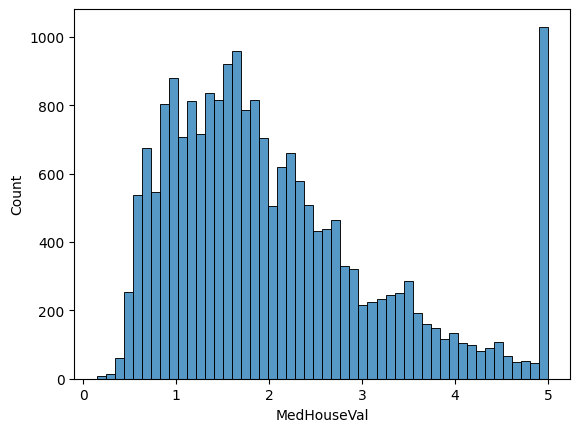

In [4]:
import seaborn as sns

sns.histplot(y, bins = 50)

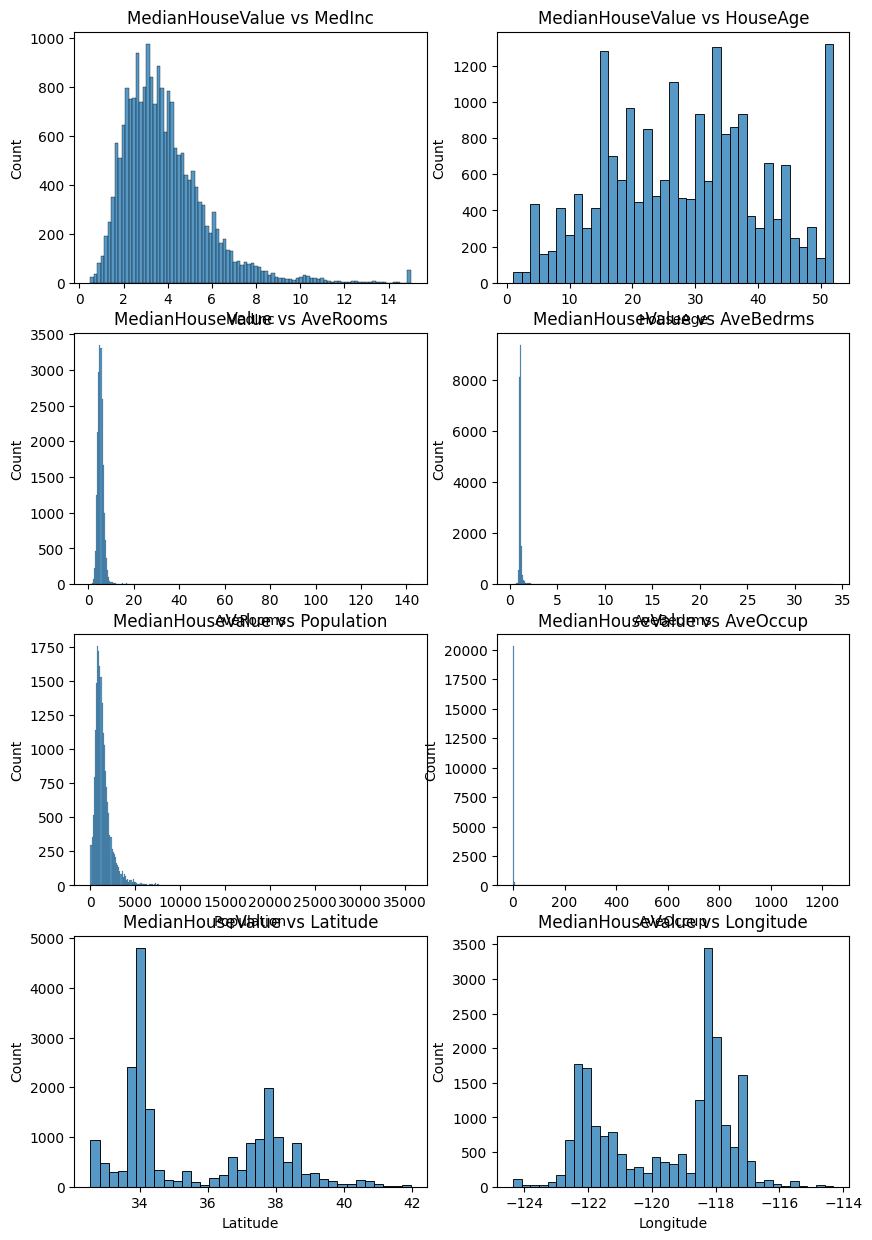

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(10,15))

for ax, col in zip(axs.ravel(), x.columns):
    sns.histplot(x=x[col],ax=ax)
    ax.set_title(f'MedianHouseValue vs {col}')

<Axes: xlabel='Longitude', ylabel='Latitude'>

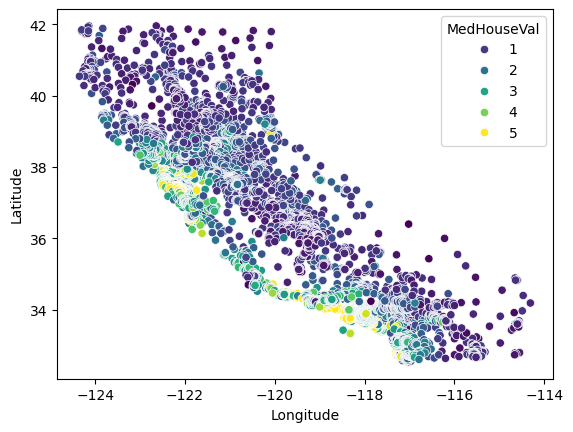

In [6]:
sns.scatterplot(x=x["Longitude"], y=x["Latitude"], hue=y, palette="viridis")

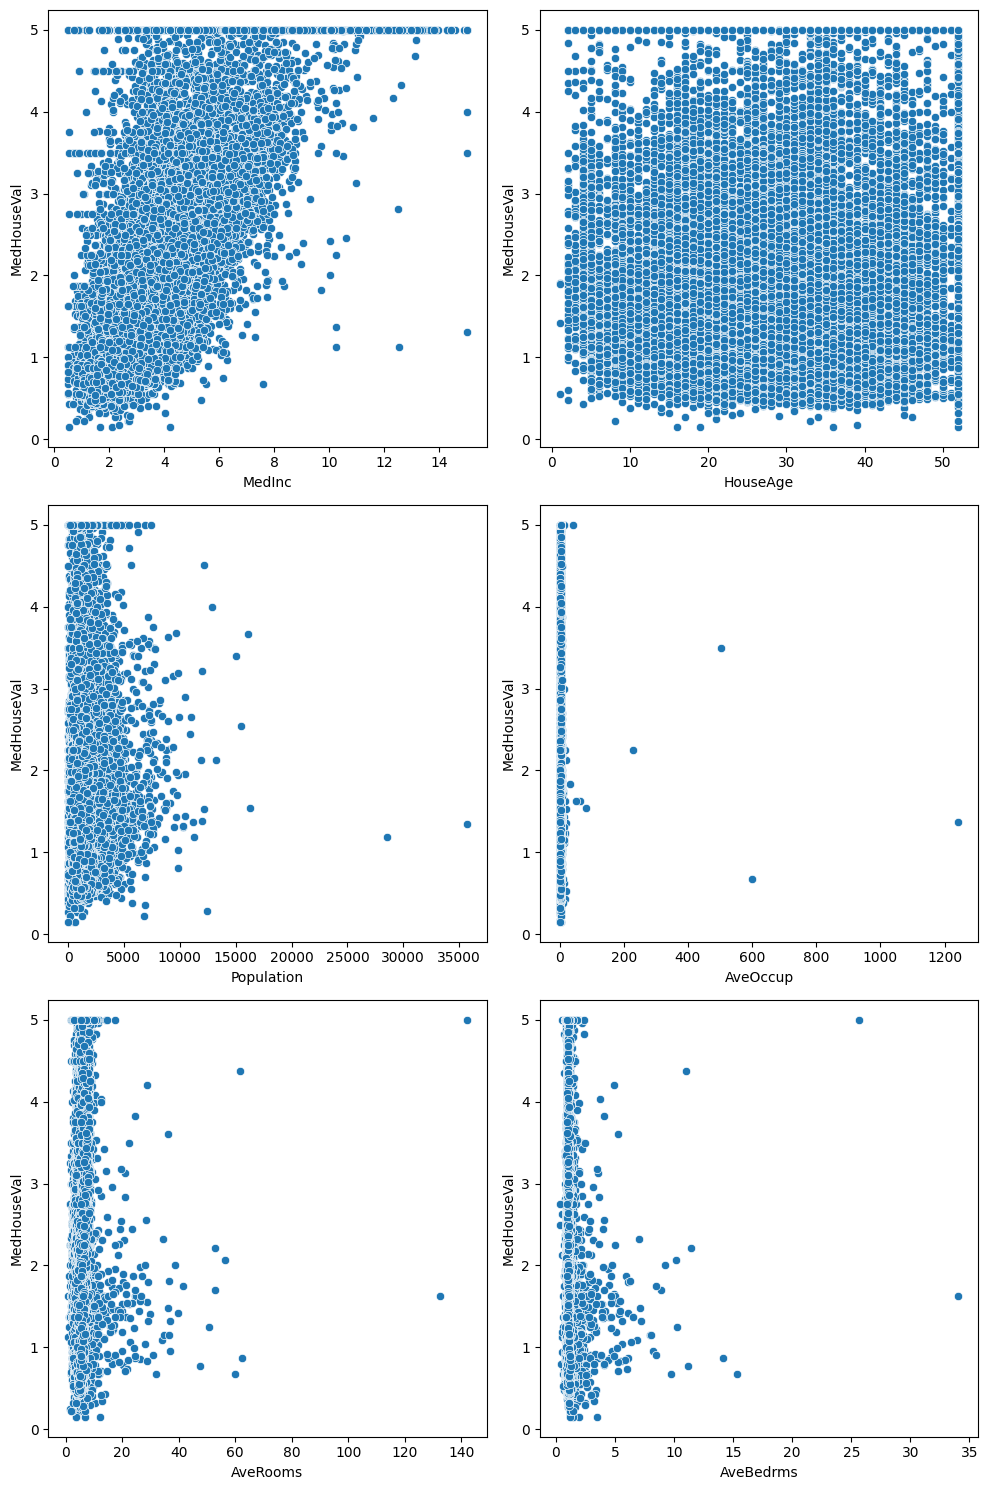

In [8]:
cols = ["MedInc", "HouseAge", "Population", "AveOccup", "AveRooms", "AveBedrms"]

fig, axs = plt.subplots(3, 2, figsize=(10,15))

for ax, col in zip(axs.ravel(), cols):
    sns.scatterplot(x=x[col], y=y, ax=ax)

plt.tight_layout()

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_trainval, y_train, y_trainval = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_trainval, y_trainval, test_size=0.5, random_state=42)

In [24]:
q1 = x_train.quantile(0.25)
q3 = x_train.quantile(0.75)
IQR = q1 - q3
lower_bound = q1 - 1.5 * IQR
upper_bound = q3 + 1.5 * IQR

x_train_capped = x_train.copy()
x_test_capped = x_test.copy()
y_val_capped = y_val.copy()

for col in x_train.columns:
    x_train_capped[col] = x_train[col].clip(lower_bound[col], upper_bound[col])
    x_test_capped[col] = x_test[col].clip(lower_bound[col], upper_bound[col])
    y_val_capped = y_val.clip(lower_bound[col], upper_bound[col])

x_train = x_train_capped
x_test = x_test_capped
y_val = y_val_capped

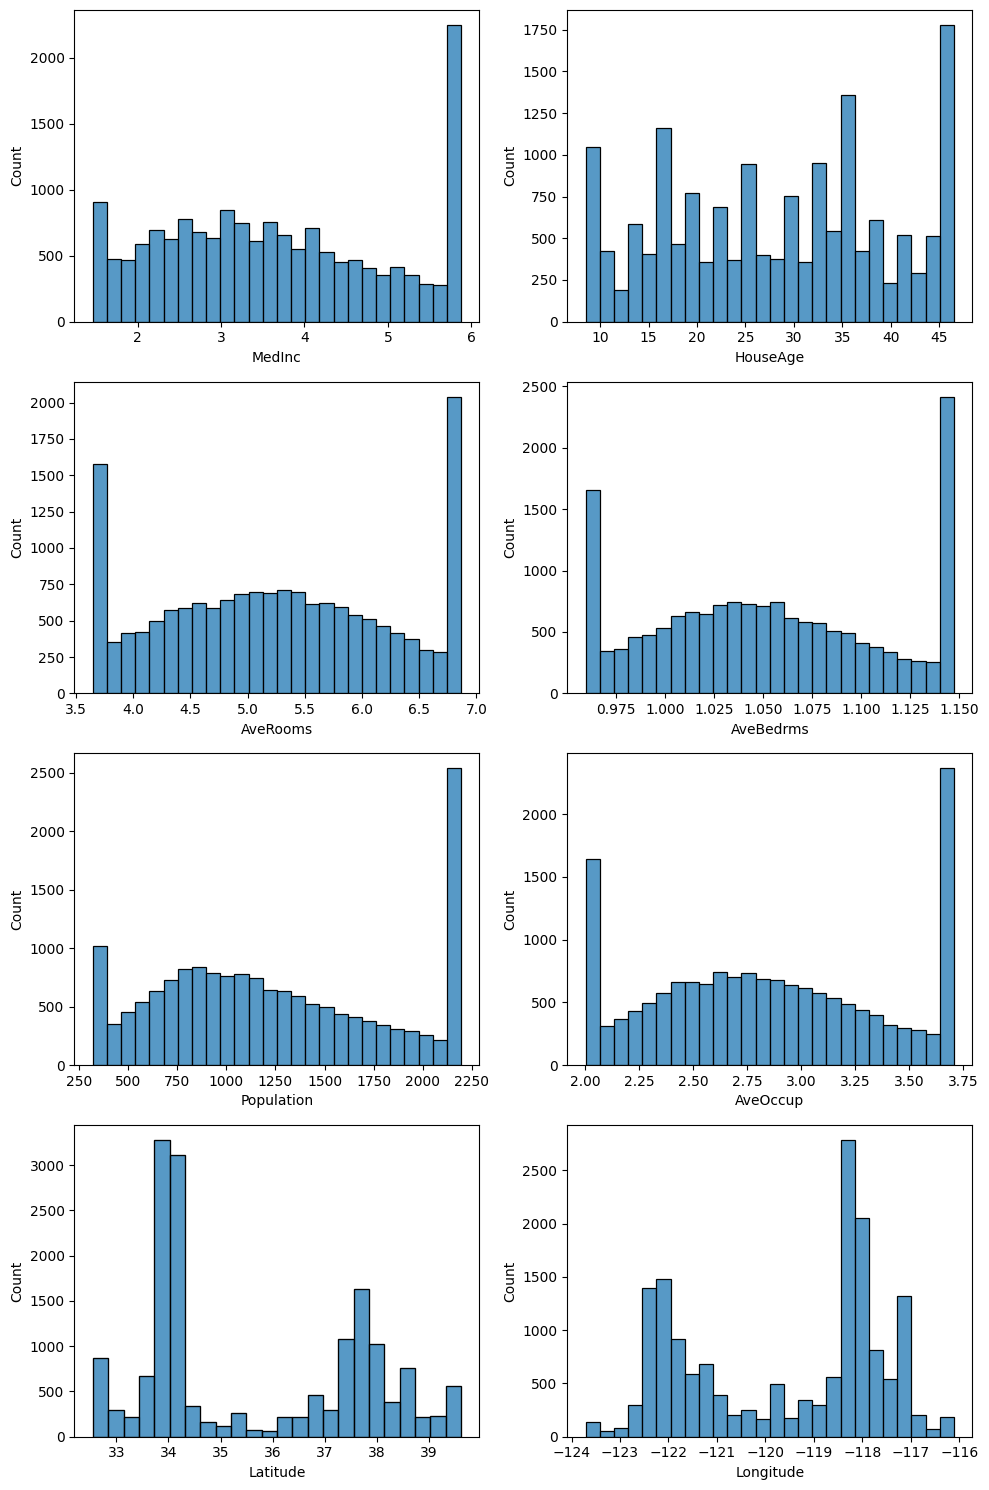

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(10,15))

for ax, col in zip(axs.flatten(), x.columns):
    sns.histplot(x_train[col],ax=ax)

plt.tight_layout()

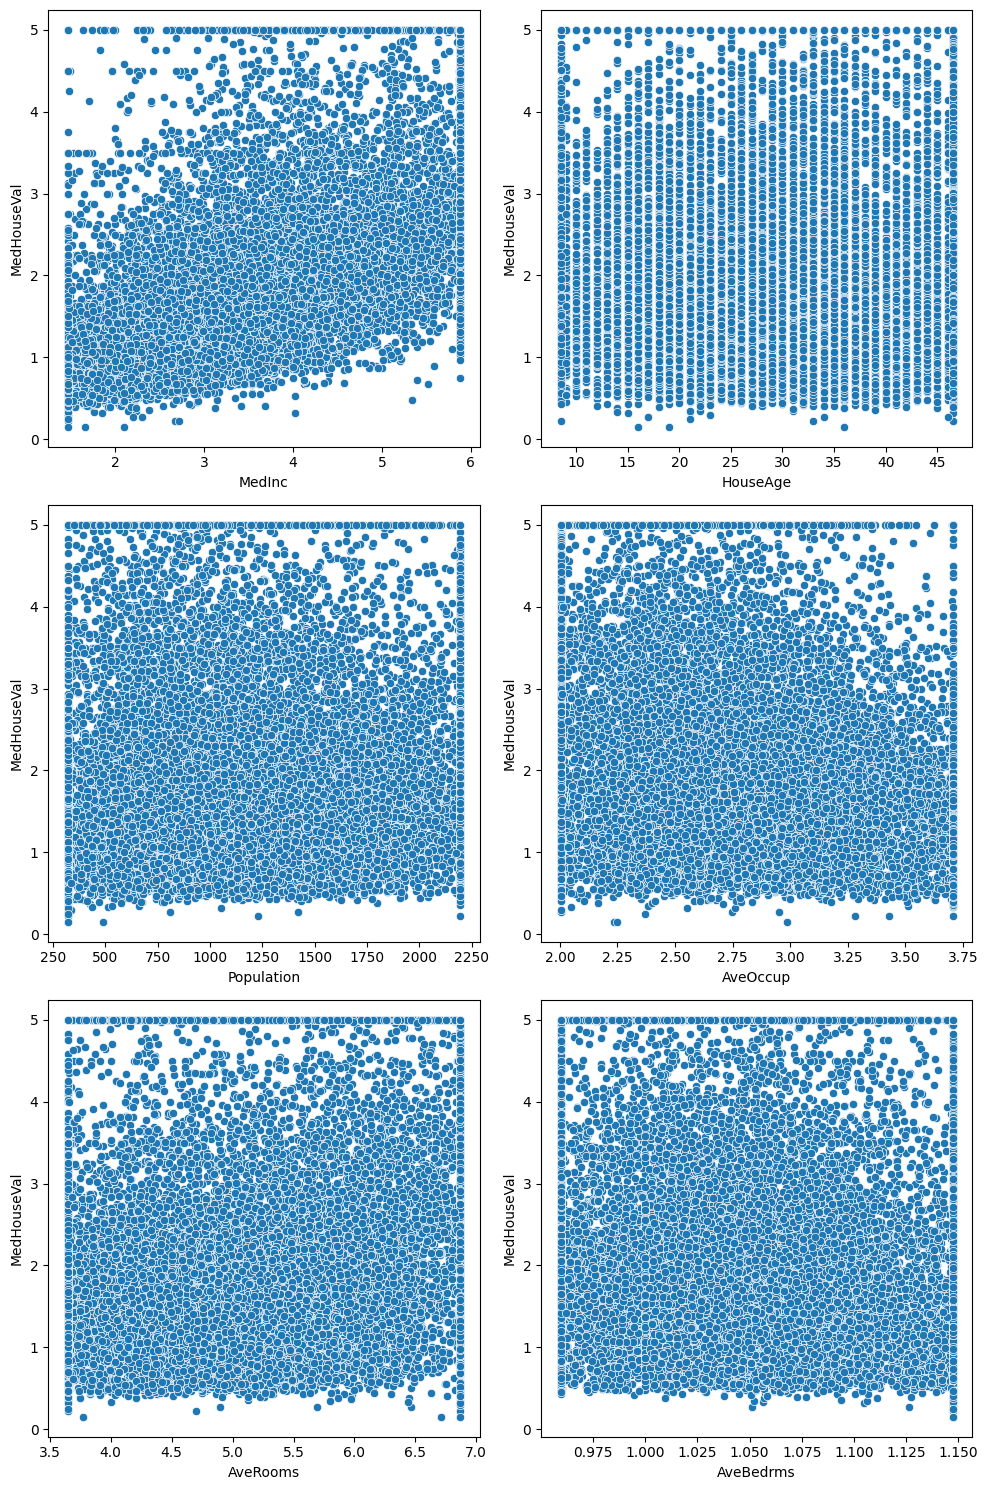

In [17]:
cols = ["MedInc", "HouseAge", "Population", "AveOccup", "AveRooms", "AveBedrms"]

fig, axs = plt.subplots(3, 2, figsize=(10,15))

for ax, col in zip(axs.ravel(), cols):
    sns.scatterplot(x=x_train[col], y=y_train, ax=ax)

plt.tight_layout()

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer


preprocessing = make_pipeline(
    ColumnTransformer([
        ("num", MinMaxScaler(), x_train.columns)
    ])
)

In [20]:
x_train_processed = preprocessing.fit_transform(x_train)
x_val_processed = preprocessing.transform(x_val)
x_test_processed = preprocessing.transform(x_test)

In [21]:
x_train_processed

array([[0.40701515, 0.64473684, 0.42576384, ..., 0.9919016 , 0.02264685,
        0.87894737],
       [0.53230549, 1.        , 0.25667819, ..., 0.        , 0.17268224,
        0.73026316],
       [0.61021256, 0.        , 0.62097324, ..., 0.42294114, 0.29865534,
        0.425     ],
       ...,
       [0.33332295, 0.72368421, 0.10539381, ..., 0.7805852 , 0.20948337,
        0.70131579],
       [0.96437474, 0.17105263, 0.85388931, ..., 0.69060797, 0.71196037,
        0.23026316],
       [0.25199413, 1.        , 0.        , ..., 0.06196966, 0.7388535 ,
        0.16973684]], shape=(16512, 8))

## Model Training Evaluation

In [27]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train_processed, y_train)
model

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

def evaluate_model(model, x, y):
    y_pred = model.predict(x)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

In [32]:
import pandas as pd

train_metrics = evaluate_model(model, x_train_processed, y_train)
test_metrics = evaluate_model(model, x_test_processed, y_test)

metrics_df = pd.DataFrame({"Train": train_metrics, "Test": test_metrics})
metrics_df.T

,MAE,MSE,RMSE,R2
Train,0.539648,0.514519,0.717300,0.615105
Test,0.539641,0.519347,0.720657,0.601535


In [35]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(50,50), solver="sgd")

model.fit(x_train_processed, y_train)

train_metrics = evaluate_model(model, x_train_processed, y_train)
test_metrics = evaluate_model(model, x_test_processed, y_test)

metrics_df = pd.DataFrame({"Train": train_metrics, "Test": test_metrics})
metrics_df.T

c:\Users\mrgok\OneDrive\Documents\CETYS\Universidad\InteligenciaComputacional\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,MAE,MSE,RMSE,R2
Train,0.437057,0.37193,0.609860,0.721772
Test,0.441791,0.37520,0.612536,0.712130


In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "hidden_layer_sizes": [(50,), (100,), (50,50)],
    "solver": ["sgd", "adam"],
    "alpha": [0.0001, 0.001, 0.01]
}

grid_search = GridSearchCV(MLPRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')

In [ ]:
grid_search.fit(x_train_processed, y_train)

c:\Users\mrgok\OneDrive\Documents\CETYS\Universidad\InteligenciaComputacional\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mrgok\OneDrive\Documents\CETYS\Universidad\InteligenciaComputacional\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mrgok\OneDrive\Documents\CETYS\Universidad\InteligenciaComputacional\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mrgok\OneDrive\Documents\CETYS\Universidad\InteligenciaComputacional\.venv\Lib\site-packages\sklearn\neural_network\_m

In [ ]:
val_metrics = evaluate_model(grid_search.best_estimator_, x_val_processed, y_val)
val_metrics